# torch quickStart : 
https://colab.research.google.com/github/pytorch/ignite/blob/master/examples/notebooks/FashionMNIST.ipynb

In [2]:
# ignite 예제

# class MyDataset(Dataset):

#     def __getitem__(self, i):
#           return {
#                  "image": self.images[i],
#                  "label": self.labels[i],
#                  "path": self.paths[i],
#           }

# # A batch from the dataloader will be something like
# #  batch['image'].shape = (4, 3, 224, 224)
# #  batch['label'].shape = (4, )

# def update_fn(engine, batch):
#     model.train()
#     x = batch['image'].cuda()
#     y = batch['label'].cuda()
#     y_pred = model(x)
#     optimizer.zero_grads()
#     loss = criterion(y_pred, y)
#     loss.backward()
#     optimizer.step()
#     return loss.item()


# trainer = Engine(update_fn)

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

`Ignite` is a High-level library to help with training neural networks in PyTorch. It comes with an `Engine` to setup a training loop, various metrics, handlers and a helpful contrib section! 

Below we import the following:
* **Engine**: Runs a given process_function over each batch of a dataset, emitting events as it goes.
* **Events**: Allows users to attach functions to an `Engine` to fire functions at a specific event. Eg: `EPOCH_COMPLETED`, `ITERATION_STARTED`, etc.
* **Accuracy**: Metric to calculate accuracy over a dataset, for binary, multiclass, multilabel cases. 
* **Loss**: General metric that takes a loss function as a parameter, calculate loss over a dataset.
* **RunningAverage**: General metric to attach to Engine during training. 
* **ModelCheckpoint**: Handler to checkpoint models. 
* **EarlyStopping**: Handler to stop training based on a score function. 

In [2]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

## dataset

In [49]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True)

/Users/rainism/miniforge3/envs/tensorflow/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-4gogm3_o/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## simple CNN

In [4]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

In [5]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

---
# ignite starts from here
---

### Instantiating Training and Evaluating Engines

Below we create 3 engines, 
- a trainer, 
- an evaluator for the training set
- an evaluator for the validation set, 
by using the `create_supervised_trainer` and `create_supervised_evaluator` and passing the required arguments.


We import the metrics from `ignite.metrics` which we want to calculate for the model. 
- Like `Accuracy`, `ConfusionMatrix`, and `Loss` 
- we pass them to `evaluator` engines which will calculate these metrics for each iteration.

* `training_history`: it stores the training loss and accuracy
* `validation_history`:it stores the validation loss and accuracy
* `last_epoch`: it stores the last epoch untill the model is trained


In [ ]:
# from ignite.engine import Engine
# from ignite.engine import Evnets
# from ignite.metrics import RunningAverage
# from ignite.contrib.handlers.tqdm_logger import ProgressBar

# class EgniteTesting(Engine):
    
#     def __init__(self, func, model, optimizer, criterion, device):
#         self.model = model
#         self.optimizer = optimizer
#         self.criterion = criterion
#         self.device = device
#         super(EgniteTesting).__init__(func)
        
#     @staticmethod
#     def trainer(engine, mini_batch):
#         engine.model.train()
        

In [74]:
# defining the number of epochs
epochs = 12

# ignite.engine : trainer
trainer = create_supervised_trainer(model, 
                                    optimizer, 
                                    criterion, 
                                    device=device)

# ignite.metrics로 부터 파생
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=10)
}

# ignite.engine : evaluator
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device) # optimizer, criterion이 없고, metrics가 들어감.

# ignite.engine : evaluator
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

last_epoch = []

To start, we will attach a metric of `RunningAverage` to track a running average of the scalar loss output for each batch.

In [75]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')
# 어케 쓰는건지 잘 모르겠음.

### EarlyStopping - Tracking Validation Loss

Now we will setup a `EarlyStopping` handler for this training process. \
EarlyStopping requires a score_function that allows the user to define whatever criteria to stop trainig. \
In this case, if the loss of the validation set does not decrease in 10 epochs, the training process will stop early.\
Since the `EarlyStopping` handler relies on the validation loss, it's attached to the `val_evaluator`. 

In [34]:
def score_function(engine):
    val_loss = engine.state.metrics['nll'] # negative log likelihood
    return -val_loss

# earlystopping조건을 설정하고
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer) # 여기서 trainer가 engine임.
# handler(earlystopping)조건이 발생시 events를 stop한다.
val_evaluator.add_event_handler(Events.COMPLETED, handler)


'''
순서
   - 0. epochs started
   - 1. iteration started
   - 2. iteration completed 
   - 3. iteration started
   - 4. iteration completed
   - 5. epochs completed
   
https://pytorch.org/ignite/v0.4.6/concepts.html#handlers
'''

'\n순서\n   - 1. epochs started\n   - 2. iteration completed \n   - 3. iteration started\n   - 4. iteration completed\n   - 5. epochs completed\n   \nhttps://pytorch.org/ignite/v0.4.6/concepts.html#handlers\n'

In [35]:
trainer # trainer 가 engine

### Attaching Custom Functions to Engine at specific Events

Below you will see ways to define your own custom functions and attaching them to various `Events` of the training process.

The functions below both achieve similar tasks, they print the results of the evaluator run on a dataset. One function does that on the training evaluator and dataset, while the other on the validation. Another difference is how these functions are attached in the trainer engine.

The first method involves using a decorator, the syntax is simple 
- `@` `trainer.on(Events.EPOCH_COMPLETED)`, means that the decorated function will be attached to the trainer and called at the end of each epoch. 

The second method involves using the add_event_handler method of trainer 
- `trainer.add_event_handler(Events.EPOCH_COMPLETED, custom_function)`. This achieves the same result as the above. 

In [76]:
# trainer에서 epoch가 끝날때(Events.EPOCH_COMPLETED)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
        # train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
        # train_loader = DataLoader
    metrics = train_evaluator.state.metrics # store metrics 정보 to Engine by calculation
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

# 같은 역할 다른 방법.
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)    

In [58]:
trainer.state_dict()

OrderedDict([('epoch_length', 938), ('max_epochs', 12), ('iteration', 15)])

## ignite.Engine.state 
is introduced in Engine to store the output of the process_function, current epoch, iteration and other helpful information. \
Each Engine contains a State, which includes the following:

- state.iteration         # 1-based, the first iteration is 1
- state.epoch             # 1-based, the first epoch is 1
- state.seed              # seed to set at each epoch
- state.dataloader        # data passed to engine
- state.epoch_length      # optional length of an epoch
- state.max_epochs        # number of epochs to run
- state.batch             # batch passed to `process_function`
- state.output            # output of `process_function` after a single iteration
- state.metrics           # dictionary with defined metrics if any
- state.times             # dictionary with total and per-epoch times fetched on keys: Events.EPOCH_COMPLETED.name and Events.COMPLETED.name

In [12]:
# event가 끝날때 할 행동. 끝날때 할 행동
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

In [47]:
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
    # https://pytorch.org/ignite/generated/ignite.handlers.checkpoint.ModelCheckpoint.html
    # (dirname, filename_prefix, save_interval, ...)
    # save_as_state_dict?, require_empty?
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})
    # 세번째 파라미터는 args인데,, 흠 pass args to handler?라는데 Handler??

In [81]:
trainer.run(train_loader, max_epochs=5)

Training Results - Epoch: 2  Avg accuracy: 10.00 Avg loss: nan
Validation Results - Epoch: 2  Avg accuracy: 10.00 Avg loss: nan
Training Results - Epoch: 3  Avg accuracy: 10.00 Avg loss: nan
Validation Results - Epoch: 3  Avg accuracy: 10.00 Avg loss: nan
Training Results - Epoch: 4  Avg accuracy: 10.00 Avg loss: nan
Validation Results - Epoch: 4  Avg accuracy: 10.00 Avg loss: nan
Training Results - Epoch: 5  Avg accuracy: 10.00 Avg loss: nan
Validation Results - Epoch: 5  Avg accuracy: 10.00 Avg loss: nan


State:
	iteration: 3752
	epoch: 5
	epoch_length: 938
	max_epochs: 5
	output: nan
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

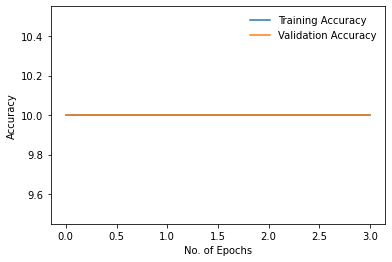

In [82]:
plt.plot(training_history['accuracy'],label="Training Accuracy")
plt.plot(validation_history['accuracy'],label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

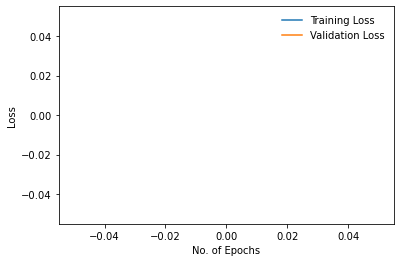

In [83]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

# custom

In [86]:
next(iter(train_loader))[0].shape

torch.Size([64, 1, 28, 28])

In [119]:
from ignite.metrics import RunningAverage
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.engine import Engine # Runs a given process_function over each batch of a dataset, emitting events as it goes.
from ignite.engine import Events # Events that are fired by the Engine during execution.


class MaximumLikelihoodEstimationEngine(Engine):
    
    def __init__(self, func, model, crit, optimizer, config):
        self.model = model
        self.crit = crit
        self.optimizer = optimizer
        self.config = config
        
        super().__init__(func)
        
    @staticmethod
    def train(engine, mini_batch):
        # 0. setting
        engine.model.train()
        
        # 1. zero_grad
        if engine.state.iteration > 1:
            engine.optimizer.zero_grad()
            
        device = next(engine.model.parameters()).device
        
        x = mini_batch[0]
        y = mini_batch[1]
        
        # forward.
        y_hat = engine.model(x)
        
        # loss
        loss = engine.crit(y_hat.contiguous().view(-1, y_hat.size(-1)),
                           y.contiguous().view(-1))
        # loss 계산은??
        loss.backward()
        
        # backward
        engine.optimizer.step()
        
        return {"loss" : loss}
    
    @staticmethod
    def valid(engine, mini_batch):
        engine.model.eval()
        
        with torch.no_grad():
            device = next(engine.model.parameters()).device
            
            x = mini_batch[0]
            y = mini_batch[1]
            
            y_hat = model(x)
            
            loss = engine.crit(
                        y_hat.contiguous().view(-1, y_hat.size(-1)),
                        y.contiguous().view(-1)
                        )
        
        return {'loss':loss}
    
    
    @staticmethod
    def attach(train_engine, valid_engine,
              training_metric_names = ['loss'],
              validation_metric_names = ['loss'],
              verbose = 1):
        def attach_running_average(engine, metric_name):
            RunningAverage(output_transform = lambda x: x[metric_name]).attach(engine, metric_name)
        
        for metric_name in training_metric_names:
            attach_running_average(train_engine, metric_name)
            
        if verbose >= 1:
            pbar = ProgressBar()
            pbar.attach(train_engine, training_metric_names)
            
        if verbose >= 2:
            
            @train_engine.on(Events.EPOCH_COMPLETED)
            def print_train_logs(engine):
                avg_loss = engine.state.metrics['loss']
                
                print(f'Epoch {engine.state.epoch} - avg_loss : {avg_loss}')
                
            
        for metric_name in validation_metric_names:
            attach_running_average(valid_engine, validation_metric_names)
        
        
        if verbose >= 1:
            pbar = ProgressBar()
            pbar.attach(valid_engine, validation_metric_names)
            
        ##
        # verbose >=2 생략
        ##
        
        
    # Resume_training, check_best, save_model
    @staticmethod
    def resume_training(engine, resume_epoch):
        engine.state.iteration = (resume_epoch - 1)*len(engine.state.dataloader)
        engine.state.epoch = (resume_epoch - 1)
    
    
    @staticmethod
    def check_best(engine):
        loss = float(engine.state.metrics['loss'])
        if loss <= engine.best_loss:
            engine.best_loss = loss
    
    
class SingleTrainer():
    
    def __init__(self, target_engine_class, config):
        
        self.target_engine_class = target_engine_class
        self.config = config
        
    def train(self, model, crit, optmizer,
             train_loader, valid_loader, n_epochs):
        
        train_engine = self.target_engine_class(
                                    self.target_engine_class.train,
                                    model, crit, optimizer, self.config)
        
        validation_engine = self.target_engine_class(
                                    self.target_engine_class.valid,
                                    model, crit, optimizer, self.config)
        
        
        self.target_engine_class.attach(train_engine, validation_engine, verbose = 1)
        
        def run_validation(engine, validation_engine, valid_loader):
            validation_engine.run(valid_loader, max_epochs = 1)
            
        train_engine.add_event_handler(Events.EPOCH_COMPLETED,
                                      run_validation,
                                      validation_engine,
                                      valid_loader)
        
#         train_engine.add_event_handler(Events.STARTED,
#                                       self.target_engine_class.resume_training,
#                                       self.config.init_epoch)

        validation_engine.add_event_handler(Events.EPOCH_COMPLETED, self.target_engine_class.check_best)
        
#         validation_engine.add_event_handler(Events.EPOCH_COMPLETED, self.target_engine_class.save_model)

        train_engine.run(train_loader, max_epochs = 2)
        return model
        

In [120]:
config = None
mle_trainer = SingleTrainer(MaximumLikelihoodEstimationEngine, config)

In [122]:
mle_trainer.train(
    cnn,
    criterion,
    optimizer,
    train_loader = train_loader,
    valid_loader = train_loader,
    n_epochs = 2)

[1/938]   0%|           [00:00<?]

Current run is terminating due to exception: unhashable type: 'list'
Engine run is terminating due to exception: unhashable type: 'list'
Engine run is terminating due to exception: unhashable type: 'list'


TypeError: unhashable type: 'list'